# Questão 1

Implemente e treine duas redes neurais artificiais para o problema de classificação de dígitos  
manuscritos, utilizando a base de dados MNIST, disponível em:  
https://www.kaggle.com/datasets/hojjatk/mnist-dataset.  

A primeira rede deve ser um Perceptron de Múltiplas Camadas (MLP) tradicional,  
enquanto a segunda deve ser uma Rede Neural Convolucional (CNN).  

Compare o desempenho das duas redes por meio da análise da curva  
do erro médio durante o treinamento e da matriz de confusão obtida no conjunto de teste.

# Questão 2

Implemente e treine uma Rede Neural Convolucional (CNN) para resolver o problema de
classificação de objetos em imagens, utilizando a base de dados CIFAR-10, disponível em:
https://www.cs.toronto.edu/~kriz/cifar.html.
Apresente a curva do erro médio ao longo do treinamento, bem como a matriz de confusão do
modelo avaliado sobre o conjunto de teste.

Loaded in this way, each of the batch files contains a dictionary with the following elements:

    data -- a 10000x3072 numpy array of uint8s. Each row of the array stores a 32x32 colour image. The first 1024 entries contain the red channel values, the next 1024 the green, and the final 1024 the blue. The image is stored in row-major order, so that the first 32 entries of the array are the red channel values of the first row of the image.
    labels -- a list of 10000 numbers in the range 0-9. The number at index i indicates the label of the ith image in the array data.


The dataset contains another file, called batches.meta. It too contains a Python dictionary object. It has the following entries:

    label_names -- a 10-element list which gives meaningful names to the numeric labels in the labels array described above. For example, label_names[0] == "airplane", label_names[1] == "automobile", etc.


In [ ]:
import tarfile
import pickle
import numpy as np

In [ ]:
def unpickle(file):
    """
    Unpickles a file from a tar.gz archive.

    Args:
        file (str): The path to the tar.gz archive.

    Returns:
        dict: The unpickled dictionary.
    """
    data = {}
    with tarfile.open(file, 'r:gz') as tar:
        for member in tar.getmembers():
            if member.name.startswith('cifar-10-batches-py/data_batch_'):
                f = tar.extractfile(member)
                if f is not None:
                    batch_data = pickle.load(f, encoding='bytes')
                    data[member.name.split('/')[-1]] = batch_data  # Store with batch name as key

    return data

In [ ]:
unpickle('/content/cifar-10-python.tar.gz')

{'data_batch_4': {b'batch_label': b'training batch 4 of 5',
  b'labels': [0,
   6,
   0,
   2,
   7,
   2,
   1,
   2,
   4,
   1,
   5,
   6,
   6,
   3,
   1,
   3,
   5,
   5,
   8,
   1,
   4,
   2,
   3,
   2,
   1,
   2,
   8,
   9,
   5,
   0,
   7,
   6,
   7,
   6,
   8,
   8,
   7,
   4,
   9,
   1,
   2,
   6,
   5,
   9,
   4,
   2,
   5,
   1,
   0,
   1,
   1,
   9,
   0,
   7,
   5,
   3,
   9,
   6,
   3,
   3,
   3,
   4,
   1,
   5,
   9,
   7,
   7,
   2,
   9,
   0,
   2,
   8,
   5,
   9,
   6,
   7,
   8,
   4,
   0,
   4,
   9,
   2,
   7,
   1,
   0,
   5,
   1,
   8,
   1,
   6,
   5,
   9,
   7,
   0,
   4,
   5,
   2,
   3,
   5,
   5,
   6,
   0,
   2,
   1,
   1,
   5,
   8,
   5,
   2,
   4,
   2,
   2,
   5,
   3,
   0,
   3,
   0,
   2,
   9,
   1,
   1,
   7,
   3,
   8,
   5,
   4,
   5,
   9,
   6,
   5,
   6,
   4,
   4,
   5,
   5,
   1,
   1,
   5,
   6,
   2,
   5,
   0,
   8,
   6,
   2,
   2,
   6,
   8,
   8,
   6,
   7,
   4,
   0,
   4,
   1,

In [ ]:
data = unpickle('/content/cifar-10-python.tar.gz')
print(data)

{'data_batch_4': {b'batch_label': b'training batch 4 of 5', b'labels': [0, 6, 0, 2, 7, 2, 1, 2, 4, 1, 5, 6, 6, 3, 1, 3, 5, 5, 8, 1, 4, 2, 3, 2, 1, 2, 8, 9, 5, 0, 7, 6, 7, 6, 8, 8, 7, 4, 9, 1, 2, 6, 5, 9, 4, 2, 5, 1, 0, 1, 1, 9, 0, 7, 5, 3, 9, 6, 3, 3, 3, 4, 1, 5, 9, 7, 7, 2, 9, 0, 2, 8, 5, 9, 6, 7, 8, 4, 0, 4, 9, 2, 7, 1, 0, 5, 1, 8, 1, 6, 5, 9, 7, 0, 4, 5, 2, 3, 5, 5, 6, 0, 2, 1, 1, 5, 8, 5, 2, 4, 2, 2, 5, 3, 0, 3, 0, 2, 9, 1, 1, 7, 3, 8, 5, 4, 5, 9, 6, 5, 6, 4, 4, 5, 5, 1, 1, 5, 6, 2, 5, 0, 8, 6, 2, 2, 6, 8, 8, 6, 7, 4, 0, 4, 1, 5, 4, 2, 0, 3, 0, 9, 5, 7, 8, 1, 1, 7, 8, 8, 3, 0, 0, 4, 7, 9, 6, 0, 9, 9, 9, 2, 1, 1, 7, 4, 3, 7, 5, 5, 7, 9, 3, 6, 9, 7, 5, 7, 1, 7, 0, 5, 6, 7, 3, 0, 4, 5, 1, 1, 8, 8, 6, 3, 2, 9, 7, 8, 1, 3, 9, 8, 6, 9, 2, 4, 4, 1, 4, 2, 4, 5, 2, 0, 1, 5, 1, 2, 1, 2, 0, 2, 4, 4, 1, 1, 2, 9, 5, 6, 4, 2, 8, 7, 2, 7, 4, 0, 2, 6, 5, 8, 8, 9, 7, 7, 3, 0, 4, 1, 3, 0, 0, 8, 7, 5, 9, 8, 7, 5, 0, 1, 4, 5, 6, 9, 2, 2, 3, 4, 5, 4, 6, 1, 8, 0, 7, 0, 7, 8, 4, 5, 6, 8, 0, 3, 4, 4, 5, 9

In [ ]:
def organize_cifar_batches(data):
    """
    Organizes CIFAR-10 data into separate arrays for images and labels, grouped by batch.

    Args:
        data (dict): The unpickled CIFAR-10 data.

    Returns:
        tuple: A tuple containing:
            - images_by_batch (list): A list of NumPy arrays, where each array contains the images for a batch.
            - labels_by_batch (list): A list of NumPy arrays, where each array contains the labels for a batch.
    """
    images_by_batch = []
    labels_by_batch = []

    num_batches = 5  # CIFAR-10 has 5 data batches

    for batch_num in range(1, num_batches + 1):
        batch_key = f'data_batch_{batch_num}'
        if batch_key in data:
            batch_data = data[batch_key]  # Extract data from current batch using its key

            images = batch_data[b'data']  # Extract images
            labels = batch_data[b'labels']  # Extract labels

            images_by_batch.append(np.array(images))
            labels_by_batch.append(np.array(labels))

    return images_by_batch, labels_by_batch

# Example usage:
data = unpickle('/content/cifar-10-python.tar.gz')
images_by_batch, labels_by_batch = organize_cifar_batches(data)

# Accessing data for batch 1:
batch1_images = images_by_batch[0]
batch1_labels = labels_by_batch[0]

print(f"Batch 1 Images Shape: {batch1_images.shape}")
print(f"Batch 1 Labels Shape: {batch1_labels.shape}")

Batch 1 Images Shape: (10000, 3072)
Batch 1 Labels Shape: (10000,)


In [ ]:
import numpy as np

def organize_cifar_batches(data):
    """
    Organizes CIFAR-10 data into separate arrays for images and labels, grouped by batch.

    Args:
        data (dict): The unpickled CIFAR-10 data.

    Returns:
        tuple: A tuple containing:
            - images (np.array): A NumPy array containing all images.
            - labels (np.array): A NumPy array containing all labels.
            - label_names (list): A list of class names for the CIFAR-10 dataset.
    """
    images_by_batch = []
    labels_by_batch = []

    num_batches = 5  # CIFAR-10 has 5 data batches

    for batch_num in range(1, num_batches + 1):
        batch_key = f'data_batch_{batch_num}'
        if batch_key in data:
            batch_data = data[batch_key]  # Extract data from current batch using its key

            images = batch_data[b'data']  # Extract images (3072 values per image)
            labels = batch_data[b'labels']  # Extract labels (10 labels)

            images_by_batch.append(np.array(images))
            labels_by_batch.append(np.array(labels))

    # Concatena as imagens e labels de todos os lotes
    images = np.concatenate(images_by_batch, axis=0)  # Combina as imagens de todos os lotes
    labels = np.concatenate(labels_by_batch, axis=0)  # Combina os rótulos de todos os lotes

    # Definindo os nomes das classes
    label_names = [
        'airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'
    ]

    return images, labels, label_names

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split

images, labels, label_names = organize_cifar_batches(data)

# Passo 1: Pré-processamento dos Dados
# Reshape do vetor de dados
data = images.reshape(50000, 3, 32, 32)  # 3 canais, 32x32 pixels por imagem
data = data.transpose(0, 2, 3, 1)  # Mudar para o formato (num_imagens, altura, largura, canais)
data = data.astype('float32')  # Converta para float32 para trabalhar com a rede
data /= 255.0  # Normalização dos valores para o intervalo [0, 1]

# Divisão entre treinamento e validação
X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size=0.2, random_state=42)

In [ ]:
# Passo 2: Construção da Rede Convolucional

model = models.Sequential()

# Primeira camada convolucional com 32 filtros e tamanho de kernel 3x3
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))

# Segunda camada convolucional com 64 filtros
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Terceira camada convolucional com 128 filtros
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Flatten para transformar as saídas 2D em 1D
model.add(layers.Flatten())

# Camada totalmente conectada com 128 neurônios
model.add(layers.Dense(128, activation='relu'))

# Camada de saída com 10 neurônios (um para cada classe de 0 a 9) e softmax para classificação multi-classe
model.add(layers.Dense(10, activation='softmax'))

# Passo 3: Compilação do Modelo
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Passo 4: Treinamento do Modelo
history = model.fit(X_train, np.array(y_train), epochs=10, validation_data=(X_val, np.array(y_val)))

# Passo 5: Avaliação do Modelo
test_loss, test_acc = model.evaluate(X_val, np.array(y_val))
print(f"Test accuracy: {test_acc}")

# Passo 6: Previsão (se necessário)
# Exemplo de previsão para a primeira imagem do conjunto de validação
predictions = model.predict(X_val[:1])
predicted_class = np.argmax(predictions, axis=1)
print(f"Predicted label: {label_names[predicted_class[0]]}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 60s 46ms/step - accuracy: 0.3314 - loss: 1.7964 - val_accuracy: 0.5508 - val_loss: 1.2473
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 80s 44ms/step - accuracy: 0.5668 - loss: 1.2160 - val_accuracy: 0.5771 - val_loss: 1.1882
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 83s 45ms/step - accuracy: 0.6391 - loss: 1.0285 - val_accuracy: 0.6535 - val_loss: 0.9889
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 81s 45ms/step - accuracy: 0.6870 - loss: 0.9005 - val_accuracy: 0.6736 - val_loss: 0.9297
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 55s 44ms/step - accuracy: 0.7197 - loss: 0.8017 - val_accuracy: 0.6946 - val_loss: 0.9005
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 86s 47ms/step - accuracy: 0.7449 - loss: 0.7227 - val_accuracy: 0.6953 - val_loss: 0.8963
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 58s 46ms/step - accuracy: 0.7721 - loss: 0.6534 - val_accuracy: 0.6999 - val_loss: 0.8950
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 81s 46ms/step - accuracy: 0.7901 -

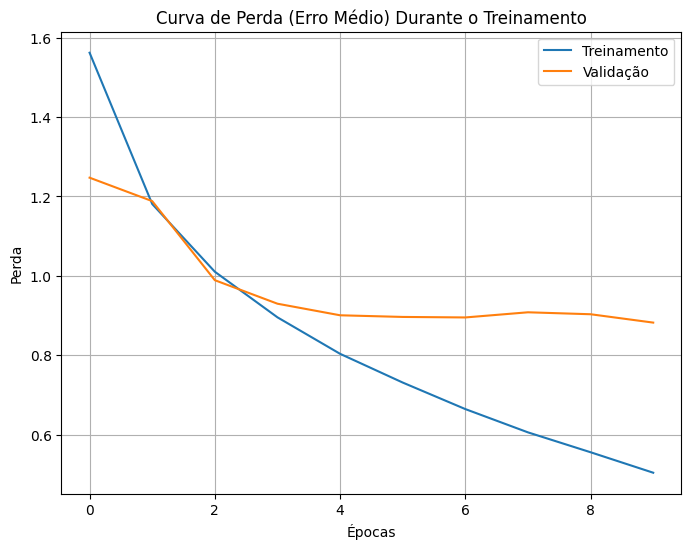

In [ ]:
import matplotlib.pyplot as plt

# Supondo que você tenha treinado um modelo com o código anterior e tenha o objeto `history`
# Exemplo: history = model.fit(X_train, np.array(y_train), epochs=10, validation_data=(X_val, np.array(y_val)))

# Plotando a curva de erro (perda)
plt.figure(figsize=(8, 6))

# Plotando a perda de treinamento
plt.plot(history.history['loss'], label='Treinamento')

# Plotando a perda de validação (se existir)
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Validação')

# Configurando o gráfico
plt.title('Curva de Perda (Erro Médio) Durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend(loc='upper right')
plt.grid(True)

# Exibindo o gráfico
plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step


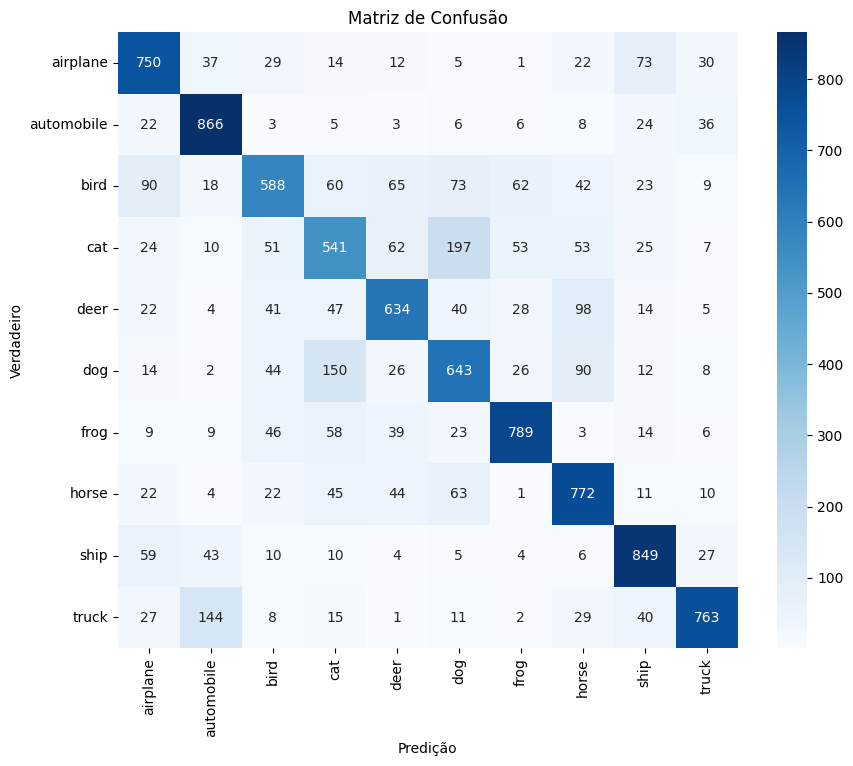

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns  # Para plotar a matriz de forma mais elegante

# Supondo que você tenha o conjunto de validação e as previsões do modelo
# X_val, y_val - Dados de validação
# model - O modelo treinado

# Previsões do modelo para o conjunto de validação
y_pred = np.argmax(model.predict(X_val), axis=1)

# Gerando a matriz de confusão
cm = confusion_matrix(y_val, y_pred)

# Plotando a matriz de confusão
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
plt.title('Matriz de Confusão')
plt.xlabel('Predição')
plt.ylabel('Verdadeiro')
plt.show()

# Questão 3

a) Implemente e treine um autoencoder utilizando o dataset Fashion-MNIST, disponível em:
https://www.kaggle.com/datasets/zalando-research/fashionmnist. O objetivo deste exercício é
compreender como esse tipo de rede neural é capaz de aprender representações comprimidas
de dados e realizar reconstruções a partir dessas representações. O autoencoder pode ser
construído utilizando apenas camadas densas (fully connected) ou, alternativamente, camadas
convolucionais e deconvolucionais.
Após o treinamento, selecione 10 imagens do conjunto de teste e utilize o modelo treinado para
gerar as reconstruções correspondentes. Apresente os resultados visualmente, exibindo lado a
lado as imagens originais e suas respectivas reconstruções, de modo que seja possível avaliar
qualitativamente o desempenho do autoencoder. Apresente também a curva do erro médio ao
longo do treinamento.

(b) Complete o exercício da questão 3(a) adicionando ruído aleatório às imagens de entrada,
com o objetivo de treinar um denoising autoencoder. Após o treinamento, utilize as 10 imagens
selecionadas na questão anterior (com o ruído aplicado) e apresente os resultados
visualmente, exibindo lado a lado as imagens originais e suas respectivas reconstruções. Avalie
qualitativamente o desempenho do modelo em remover o ruído e preservar as características
das imagens originais.

## a)

In [129]:
import kagglehub
from keras.layers import Dense, Input, Conv2D, LSTM, MaxPool2D, UpSampling2D
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from numpy import argmax, array_equal
import matplotlib.pyplot as plt
from keras import Input, Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from random import randint
from skimage.util import random_noise
import pandas as pd
import numpy as np
from PIL import Image

In [43]:
# Download latest version
path = kagglehub.dataset_download("zalando-research/fashionmnist")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/zalando-research/fashionmnist/versions/4


In [44]:
# Carrega os dados de treinamento
train_df = pd.read_csv(path + '/fashion-mnist_train.csv')

# Carrega os dados de teste
test_df = pd.read_csv(path + '/fashion-mnist_test.csv')

In [45]:
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [46]:
X_train = train_df.drop('label', axis=1).values
y_train = train_df['label'].values

X_test = test_df.drop('label', axis=1).values
y_test = test_df['label'].values

In [47]:
X_train = X_train / 255
X_test = X_test / 255

In [49]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

In [50]:
X_train = X_train.reshape(-1, 784)
X_val = X_val.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

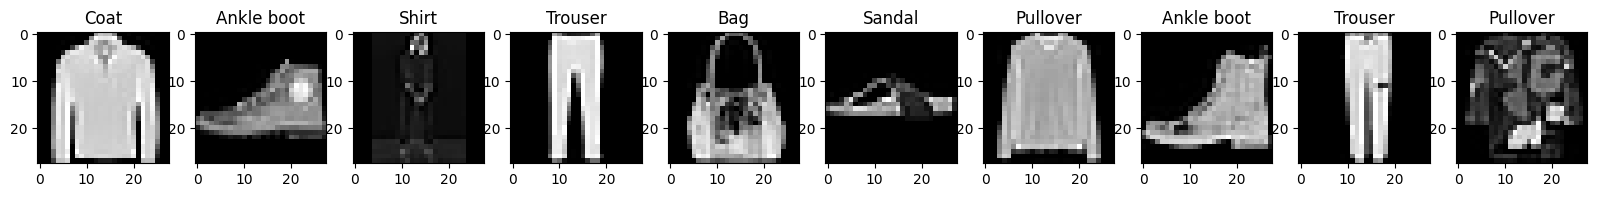

In [63]:
labeldict = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

fig, ax = plt.subplots(1, 10, figsize=(20, 2))
for i in range(10):
    # Reshape the image before displaying
    image = X_train[i].reshape(28, 28)
    ax[i].imshow(image, cmap='gray')
    ax[i].set_title(labeldict[y_train[i]])

In [53]:
## input layer
input_layer = Input(shape=(784,))

## encoding architecture
encode_layer1 = Dense(1500, activation='relu')(input_layer)
encode_layer2 = Dense(1000, activation='relu')(encode_layer1)
encode_layer3 = Dense(500, activation='relu')(encode_layer2)

## latent view
latent_view   = Dense(10, activation='sigmoid')(encode_layer3)

## decoding architecture
decode_layer1 = Dense(500, activation='relu')(latent_view)
decode_layer2 = Dense(1000, activation='relu')(decode_layer1)
decode_layer3 = Dense(1500, activation='relu')(decode_layer2)

## output layer
output_layer  = Dense(784)(decode_layer3)

model = Model(input_layer, output_layer)

In [54]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 1500)                │       1,177,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 1000)                │       1,501,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 500)                 │         500,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 10)                  │           5,010 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 500)                 │           5,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 1000)                │         501,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 1500)                │       1,501,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 784)                 │       1,176,784 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,368,794 (24.30 MB)

 Trainable params: 6,368,794 (24.30 MB)

 Non-trainable params: 0 (0.00 B)

In [70]:
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')
model.fit(X_train, X_train, epochs=5, batch_size=2048, validation_data=(X_val, X_val), callbacks=[early_stopping])

Epoch 1/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - loss: 0.0838 - mae: 0.1854 - val_loss: 0.0313 - val_mae: 0.1194
Epoch 2/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - loss: 0.0281 - mae: 0.1095 - val_loss: 0.0230 - val_mae: 0.0935
Epoch 3/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - loss: 0.0222 - mae: 0.0914 - val_loss: 0.0204 - val_mae: 0.0865
Epoch 4/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - loss: 0.0199 - mae: 0.0852 - val_loss: 0.0192 - val_mae: 0.0831
Epoch 5/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - loss: 0.0189 - mae: 0.0822 - val_loss: 0.0187 - val_mae: 0.0811


In [71]:
model.history.history.keys()

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])

In [ ]:
# plot da curva do erro médio
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [59]:
preds = model.predict(X_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step


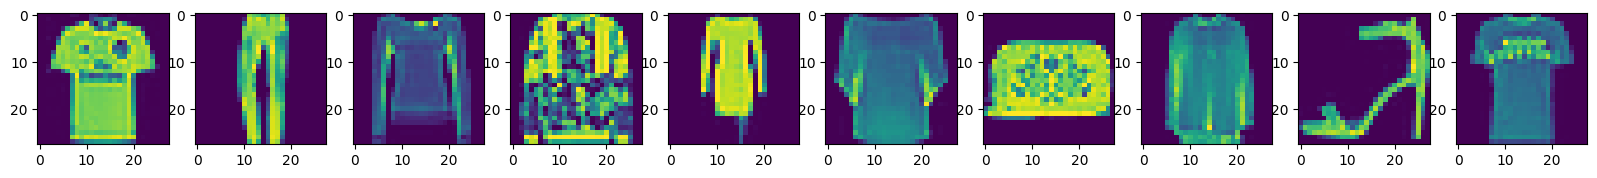

In [60]:
f, ax = plt.subplots(1,10)
f.set_size_inches(20, 20)
for i in range(10):
    ax[i].imshow(X_test[i].reshape(28, 28))
plt.show()

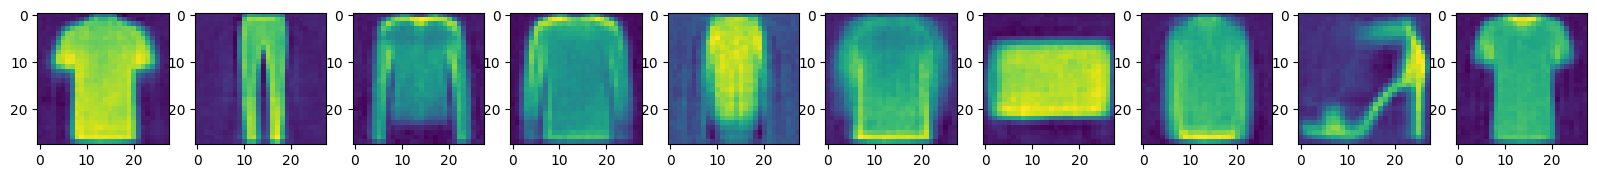

In [61]:
f, ax = plt.subplots(1,10)
f.set_size_inches(20, 20)
for i in range(10):
    ax[i].imshow(preds[i].reshape(28, 28))
plt.show()

## b)

In [113]:
X_train = train_df.drop('label', axis=1).values
y_train = train_df['label'].values

X_test = test_df.drop('label', axis=1).values
y_test = test_df['label'].values

In [114]:
X_train = X_train / 255
X_test = X_test / 255

In [115]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

In [116]:
X_train = X_train.reshape(-1, 28, 28, 1)
X_val = X_val.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

In [117]:
# Adicionar ruído gaussiano ao conjunto de treino
train_images_noisy = [random_noise(img, mode='gaussian', var=0.01) for img in X_train]

# Adicionar ruído gaussiano ao conjunto de validação
val_images_noisy = [random_noise(img, mode='gaussian', var=0.01) for img in X_val]

# Adicionar ruído gaussiano ao conjunto de teste
test_images_noisy = [random_noise(img, mode='gaussian', var=0.01) for img in X_test]

In [118]:
train_images_noisy = np.array(train_images_noisy).reshape(-1, 28, 28, 1)
val_images_noisy = np.array(val_images_noisy).reshape(-1, 28, 28, 1)
test_images_noisy = np.array(test_images_noisy).reshape(-1, 28, 28, 1)

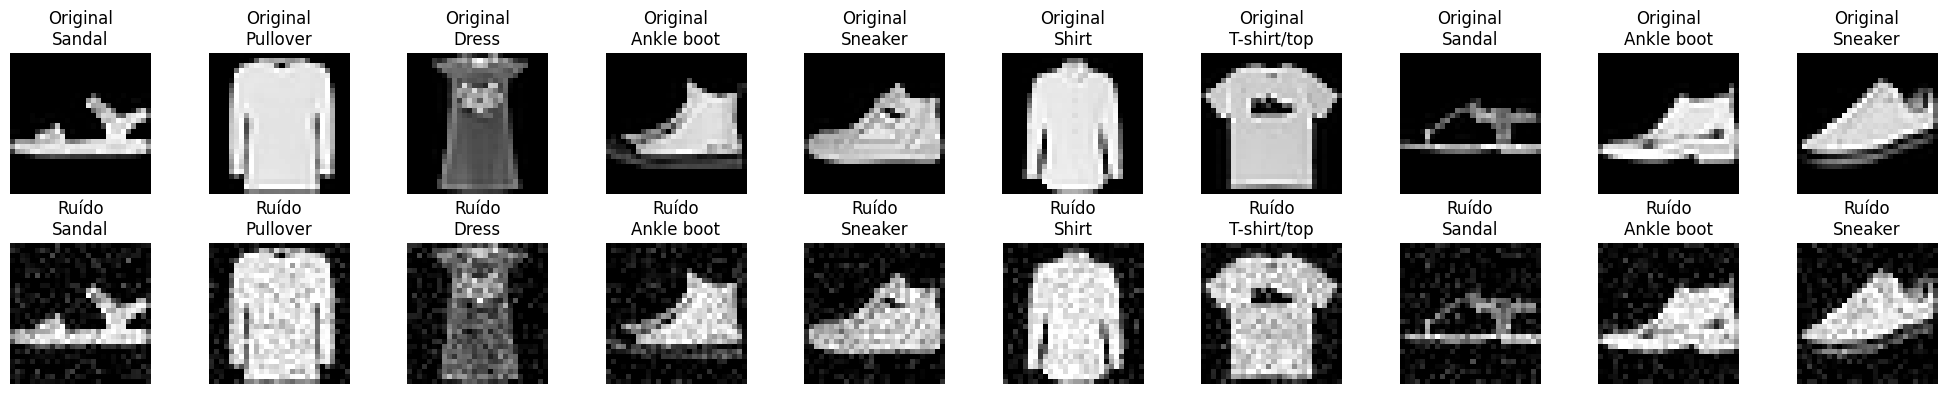

In [119]:
fig, ax = plt.subplots(2, 10, figsize=(20, 4))

for i in range(10):
    # Linha 1: Imagens originais
    ax[0, i].imshow(X_train[i], cmap='gray')
    ax[0, i].set_title(f"Original\n{labeldict[y_train[i]]}")
    ax[0, i].axis('off')

    # Linha 2: Imagens com ruído
    ax[1, i].imshow(train_images_noisy[i], cmap='gray')
    ax[1, i].set_title(f"Ruído\n{labeldict[y_train[i]]}")
    ax[1, i].axis('off')

plt.tight_layout()
plt.show()

In [120]:
## input layer
input_layer = Input(shape=(28,28, 1))

## encoding architecture
encode_layer1 = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
encode_layer1 = MaxPool2D((2, 2))(encode_layer1)

encode_layer2 = Conv2D(32, (3, 3), activation='relu', padding='same')(encode_layer1)
encode_layer2 = MaxPool2D((2, 2))(encode_layer2)

encode_layer3 = Conv2D(16, (3, 3), activation='relu', padding='same')(encode_layer2)

## latent view
latent_view   = MaxPool2D((2, 2), padding='same')(encode_layer3)

## decoding architecture
decode_layer1 = Conv2D(16, (3, 3), activation='relu', padding='same')(latent_view)
decode_layer1 = UpSampling2D((2, 2))(decode_layer1)

decode_layer2 = Conv2D(32, (3, 3), activation='relu', padding='same')(decode_layer1)
decode_layer2 = UpSampling2D((2, 2))(decode_layer2)

decode_layer3 = Conv2D(64, (3, 3), activation='relu', padding='same')(decode_layer2)
decode_layer3 = UpSampling2D((2, 2))(decode_layer3)


output_layer  = Conv2D(1, (3, 3), padding='same')(decode_layer3)

model = Model(input_layer, output_layer)

In [121]:
model.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)          │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_60 (Conv2D)                   │ (None, 28, 28, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_27 (MaxPooling2D)      │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_61 (Conv2D)                   │ (None, 14, 14, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_28 (MaxPooling2D)      │ (None, 7, 7, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_62 (Conv2D)                   │ (None, 7, 7, 16)            │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_29 (MaxPooling2D)      │ (None, 4, 4, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_63 (Conv2D)                   │ (None, 4, 4, 16)            │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_24 (UpSampling2D)      │ (None, 8, 8, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_64 (Conv2D)                   │ (None, 8, 8, 32)            │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_25 (UpSampling2D)      │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_65 (Conv2D)                   │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_26 (UpSampling2D)      │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_66 (Conv2D)                   │ (None, 32, 32, 1)           │             577 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 49,761 (194.38 KB)

 Trainable params: 49,761 (194.38 KB)

 Non-trainable params: 0 (0.00 B)

In [112]:
model.compile(optimizer='adam', loss='mse')
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')
model.fit(train_images_noisy, train_images_noisy, epochs=20, batch_size=2048, validation_data=(val_images_noisy, val_images_noisy), callbacks=[early_stopping])

Epoch 1/20


ValueError: Dimensions must be equal, but are 28 and 32 for '{{node compile_loss/mse/sub}} = Sub[T=DT_FLOAT](data_1, functional_10_1/conv2d_59_1/Add)' with input shapes: [?,28,28,1], [?,32,32,1].

In [1]:
model = Sequential()
# encoder network
model.add(Conv2D(35, 3, activation= 'relu', padding='same', input_shape = (28,28,1)))
model.add(MaxPooling2D(2, padding= 'same'))
model.add(Conv2D(25, 3, activation= 'relu', padding='same'))
model.add(MaxPooling2D(2, padding= 'same'))
#decoder network
model.add(Conv2D(25, 3, activation= 'relu', padding='same'))
model.add(UpSampling2D(2))
model.add(Conv2D(35, 3, activation= 'relu', padding='same'))
model.add(UpSampling2D(2))
model.add(Conv2D(1,3,activation='sigmoid', padding= 'same')) # output layer
model.compile(optimizer= 'adam', loss = 'mse')
model.fit(train_images_noisy, train_images_noisy,
                epochs=15,
                batch_size=128,
                validation_data=(test_images_noisy, test_images_noisy))

NameError: name 'Sequential' is not defined

# Questão 4

Implemente uma Rede Neural Recorrente (RNN), como por exemplo uma LSTM ou GRU,
para o problema de Análise de Sentimentos, utilizando a base de dados de resenhas de filmes
do IMDb (Internet Movie Database).
Essa base contém 50 mil resenhas em inglês, sendo 25 mil para treinamento e 25 mil para
teste, cada uma acompanhada de uma avaliação binária que indica se a resenha é negativa (0)
ou positiva (1). A base está disponível em:
https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews.
Descreva o processo de pré-processamento dos dados, a arquitetura da RNN implementada,
os parâmetros utilizados no treinamento e os principais resultados obtidos (como acurácia,
curva de erro e exemplos de inferências (classificações no conjunto de teste)).